In [1]:
import pandas as pd
import re
from collections import Counter
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Ignore future warnings just to make the notebook look a little neater
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Issues with Data:

bankruptcy_Test_X.csv: Does not contain a class column so we can check our accuracy
data.csv: Does not use the same attribute list as our bankruptcy_Train, which is larger so we can't use this either

In [2]:
# Import our data as csv files from Kaggle, values are already normalized and split into test and training data
test_x = pd.read_csv('bankruptcy_Test_X.csv')
train = pd.read_csv('bankruptcy_Train.csv')

In [3]:
cols = list(train.columns)
x_cols = cols[:-1]

X = train[x_cols]
y = train['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
train.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.007954,-0.007140,-0.003544,0.005005,-0.004687,0.001455,-0.006963,0.009053,0.006763,0.007456,...,0.009804,0.005208,-0.009751,-0.002655,0.004548,0.014331,-0.006864,0.020750,-0.003984,0.020300
std,1.396405,1.409440,1.015494,0.908020,1.394750,1.286713,1.412509,1.064426,1.171199,1.407349,...,0.017370,0.718682,0.026124,0.467139,1.252571,1.171160,0.277288,1.115182,0.930875,0.141032
min,-9.474787,-140.604555,-25.597146,-0.381641,-138.720013,-26.249562,-141.176615,-0.966015,-1.294340,-2.528495,...,-1.657288,-42.381245,-0.037484,-3.218490,-0.048598,-0.412525,-0.022204,-0.743297,-0.050969,0.000000
25%,-0.079776,-0.055604,-0.516971,-0.192306,0.006798,-0.016047,-0.008018,-0.445667,-0.388184,-0.068584,...,0.009315,0.003199,-0.010766,-0.022740,-0.043418,-0.221237,-0.016847,-0.371384,-0.041603,0.000000
50%,-0.019204,0.000246,0.003186,-0.117972,0.007302,-0.016047,0.004280,-0.260150,-0.307842,0.000253,...,0.009838,0.010013,-0.009924,-0.020438,-0.039928,-0.139653,-0.013821,-0.180311,-0.034319,0.000000
75%,0.081218,0.056957,0.585722,0.022705,0.007753,0.016026,0.024222,0.098874,0.156638,0.070036,...,0.010693,0.019900,-0.009416,-0.014401,-0.031820,-0.002210,-0.009476,0.133244,-0.020507,0.000000
max,137.557872,2.004925,3.324327,60.825460,11.556238,121.354736,0.623095,47.504463,62.936396,140.123299,...,0.036727,37.405312,2.551674,27.969785,117.341069,59.139158,23.970250,62.527240,90.774695,1.000000


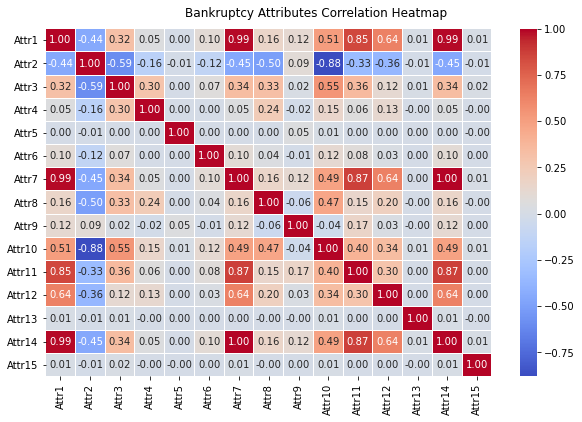

In [34]:
# Exploratory Data Analysis where we can see how attributes relate to each other

attr_list1 = x_cols[:15]
attr_list2 = x_cols[15:30]
attr_list3 = x_cols[30:45]
attr_list4 = x_cols[45:]
corr_df = X_train[attr_list1]


import seaborn as sns
f, ax = plt.subplots(figsize=(10, 6))
corr = corr_df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Bankruptcy Attributes Correlation Heatmap', fontsize=12)

In [5]:
#Metrics function we can use to evaluate our models
def confusion_matrix(y_true, y_pred):
    """ Generate a confusion matrix.
    y = actual outcomes (0, 1, 2, ...)
    y_pred = predicted outcomes (0, 1, 2, ...)
    return confusion matrix as a numpy array
    """
    
    # Find unique identifiers
    unique_classes = set(y_true) | set(y_pred)
    n_classes = len(unique_classes)
    
    # Create matrix (all zeros)
    matrix = np.zeros(shape=(n_classes, n_classes), dtype=int)
    
    # Pair up each actual outcome with the corresponding prediction
    actual_prediction = list(zip(y_true, y_pred))
    
    # For each pair, increment the correct position in the matrix
    for i,j in actual_prediction:
        matrix[i,j] += 1
        
    return matrix

def metrics(y, y_pred):
    '''
    Parameters:
    y, y_pred (Pandas Series): series representing actual labels(y) and predicted outcomes(y_pred)
    
    Returns:
    model accuracy, sensitivity, specificity, precision, f1-score
    '''
    # Create a confusion matrix with our two series
    cm = confusion_matrix(y, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
     # Accuracy Calcs
    accuracy = (TN + TP)/(TN + FP + FN + TP) 
    
    # Sensitivity Calcs
    # TP (1,1)/ (TP (1,1) + FN (1,0)) <- wherever y actual = 1
    sensitivity = TP/(TP + FN) 
    
    # Specificity Calc
    specificity = TN/(TN + FP) 
    
    # Precision Calc
    precision = TP/(TP + FP) 
    
    # F1 Score Calc
    f1_score = 2 * ((precision * sensitivity) / (precision + sensitivity)) if (precision + sensitivity) != 0 else 0
    
    #print(f'Accuracy: {accuracy} \nSensitivity: {sensitivity}\nSpecificity: {specificity}\nPrecision: {precision}\nf1 score: {f1_score}')
    return {'Accuracy': round(accuracy, 4), 'Sensitivity': round(sensitivity, 4), 
            'Specificity': round(specificity, 4), 'Precision': round(precision, 4), 'f1 score': round(f1_score, 4)}

In [6]:
# Check the amount of companies that went bankrupt in our data
# 0 = did not bankrupt, 1 = bankrupt
Counter(train['class'].tolist())

Counter({0: 9797, 1: 203})

## Naive Bayes (not going to use)
Despite our project proposal suggesting Naive Bayes as a way to classify our data, we decided against it. Reason being, we wanted to implement as many of our attributes in our data as possible, and in doing so, it would be more difficult to calculate probabilities given the sheer amount of attributes that our data contains. Theoretically, we could split our data into smaller subsets of attributes, but we didn't think that it would provide an accurate enough classification given that our attribute list is over 60 attributes

## K-Nearest Neighbors

In [7]:
from sklearn.neighbors import KNeighborsClassifier
# Create the KNN model
k = 5 # Set the number of neighbors to consider
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Make predictions on the testing data and evaluate the model
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
knn_m = metrics(y_test, y_pred)
print("Metrics:", knn_m)

Metrics: {'Accuracy': 0.9825, 'Sensitivity': 0.0303, 'Specificity': 0.9985, 'Precision': 0.25, 'f1 score': 0.0541}


## Neural Network

Another approach, inspired by https://www.kaggle.com/code/karthik7395/binary-classification-using-neural-networks/notebook

make sure to run these if not already installed:
- pip install keras
- pip install tensorflow --user

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

In [9]:
hidden_units=100
learning_rate=0.01
hidden_layer_act='tanh'
output_layer_act='sigmoid'
no_epochs=100

model = Sequential()

In [10]:
model.add(Dense(64, input_shape=(64,), activation=hidden_layer_act))
model.add(Dense(64, activation=hidden_layer_act))
model.add(Dense(1, activation=output_layer_act))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,385
Trainable params: 8,385
Non-trainable params: 0
_________________________________________________________________


In [11]:
sgd=optimizers.SGD(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=['acc'])

In [15]:
model.fit(X_train, y_train, epochs = no_epochs, batch_size = len(train), verbose=2)

predictions = model.predict(X_test)

rounded = [int(round(x[0])) for x in predictions]

accuracy = sum(1 for x,y in zip(rounded,y_test) if x == y) / len(y_test)

In [16]:
nn_m = metrics(y_test, rounded)
print("Metrics:", nn_m)
accuracy = accuracy_score(y_test, y_pred)

Metrics: {'Accuracy': 0.981, 'Sensitivity': 0.0, 'Specificity': 0.9975, 'Precision': 0.0, 'f1 score': 0}


# Perceptron Algorithm

In [17]:
def scores(X, w):
    bias = w[0]
    weights = w[1:]
    
    return bias + X.dot(weights)

def predict(X, w):
    score = scores(X, w)
    y_pred = (score >= 0).astype(int)
    
    return y_pred

def calculate_error(y_true, y_pred, scores):
    small_val = 1e-8
    errors = np.abs(y_true - y_pred) * np.abs(scores + small_val)
    return errors.mean()

In [18]:
def perceptron(data, alpha, epochs, subset=None):
    x = data[subset] if subset else data.iloc[:, :-1]
    y = data.iloc[:, -1]   
    w_coef = len(x.columns) + 1
    
    w = list()
    for i in range(w_coef):
        w.append(np.random.randint(-1,2))   
    mpe = list()
    acc = list()
    
    for epoch in range(epochs):
        y_pred = predict(x, w)
        score = scores(x, w)
        mpe.append(calculate_error(y, y_pred, score))
        
        w[0] = w[0] + (alpha * (y - y_pred)).sum()
        for i in range(1, len(x.columns)+1):
            w[i] = w[i] + (alpha * (y - y_pred) * data[x.columns[i-1]]).sum()
        acc.append(metrics(y, y_pred)['Accuracy'])
        
    return w, mpe, acc

In [19]:
y = train['class']
x = train.iloc[:, :-1]
w, mpe, acc = perceptron(train, 0.0001, 1000)
p_metrics = metrics(y, predict(x, w))

{'Accuracy': 0.9772,
 'Sensitivity': 0.0345,
 'Specificity': 0.9967,
 'Precision': 0.1795,
 'f1 score': 0.0579}

## Other SKlearn Classification Algorithms

In [20]:
# adding some other classification algorithms through sklearn, idk if we need this tho

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# assume X and y are the data and labels, respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define and fit the models
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
lr.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

# make predictions on the test data using each model
lr_preds = lr.predict(X_test)
dt_preds = dt.predict(X_test)
rf_preds = rf.predict(X_test)

# calculate the metrics for each model
lr_metrics = metrics(y_test, lr_preds)
dt_metrics = metrics(y_test, dt_preds)
rf_metrics = metrics(y_test, rf_preds)

# print the metrics for each model
print("Logistic Regression:", lr_metrics)
print("Decision Tree:", dt_metrics)
print("Random Forest:", rf_metrics)


Logistic Regression: {'Accuracy': 0.979, 'Sensitivity': 0.0263, 'Specificity': 0.9975, 'Precision': 0.1667, 'f1 score': 0.0455}
Decision Tree: {'Accuracy': 0.972, 'Sensitivity': 0.3421, 'Specificity': 0.9842, 'Precision': 0.2955, 'f1 score': 0.3171}
Random Forest: {'Accuracy': 0.981, 'Sensitivity': 0.0263, 'Specificity': 0.9995, 'Precision': 0.5, 'f1 score': 0.05}


## Visualization

In [ ]:
# We want to compare and contrast how each of our six binary classification algorithms performed with their models
all_metrics = [knn_m, nn_m, p_metrics, lr_metrics, dt_metrics, rf_metrics]
accuracies = []
